In [78]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [79]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [80]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [81]:
knn = KNeighborsClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [85]:
param_grid = [
    {
        'metric': ['minkowski'],
        'p': [1, 2],  # hyperparametro usado apenas com a metrica minkowski
        'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'weights': ['uniform', 'distance']
    },
    {
        'metric': ['euclidean', 'manhattan'],
        'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'weights': ['uniform', 'distance']
    }
]

In [92]:
def train_random_search(X, y, estimator, grid):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        n_iter=20
    )

    random_search.fit(X, y)

    return random_search

In [94]:
def get_results(r_search):
    results = pd.DataFrame(r_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_metric', 'param_n_neighbors', 'param_p',
            'param_weights', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_train_precision_macro', 
            'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [88]:
pd.set_option('display.max_columns', None)

In [95]:
grid_search = train_random_search(X_train, y_train, knn, param_grid)
results = get_results(grid_search)

In [96]:
results.head(10)

,mean_fit_time,mean_score_time,param_metric,param_n_neighbors,param_p,param_weights,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
6,0.009604,0.412308,minkowski,1,1.0,uniform,1.000000,0.788880,19,1.000000,0.620891,19,1.000000,0.625106,1,1.000000,0.622797,1
8,0.007911,0.357061,manhattan,1,NaN,uniform,1.000000,0.788880,19,1.000000,0.620891,19,1.000000,0.625106,1,1.000000,0.622797,1
10,0.012655,0.073173,minkowski,3,2.0,uniform,0.897491,0.814295,16,0.841533,0.634715,16,0.754147,0.594270,3,0.787485,0.606140,3
19,0.007905,0.111210,euclidean,3,NaN,uniform,0.897491,0.814295,16,0.841533,0.634715,16,0.754147,0.594270,3,0.787485,0.606140,3
3,0.010911,0.068611,euclidean,3,NaN,distance,1.000000,0.814124,18,1.000000,0.634471,18,1.000000,0.594168,5,1.000000,0.605993,5
2,0.011061,0.123206,euclidean,5,NaN,uniform,0.873314,0.828449,13,0.807050,0.660761,13,0.671023,0.587807,6,0.708781,0.603121,6
11,0.014079,0.079761,minkowski,5,2.0,uniform,0.873314,0.828449,13,0.807050,0.660761,13,0.671023,0.587807,6,0.708781,0.603121,6
12,0.013355,0.072969,minkowski,5,2.0,distance,1.000000,0.827767,15,1.000000,0.659510,15,1.000000,0.587807,8,1.000000,0.603086,8
18,0.009407,0.410176,manhattan,7,NaN,distance,1.000000,0.833392,10,1.000000,0.668503,10,1.000000,0.573715,9,1.000000,0.586944,9
4,0.016074,0.093480,minkowski,7,2.0,distance,1.000000,0.832026,12,1.000000,0.665610,11,1.000000,0.570811,10,1.000000,0.582874,10


In [99]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = ["param_n_neighbors", "param_metric", "param_weights", "param_p"]
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

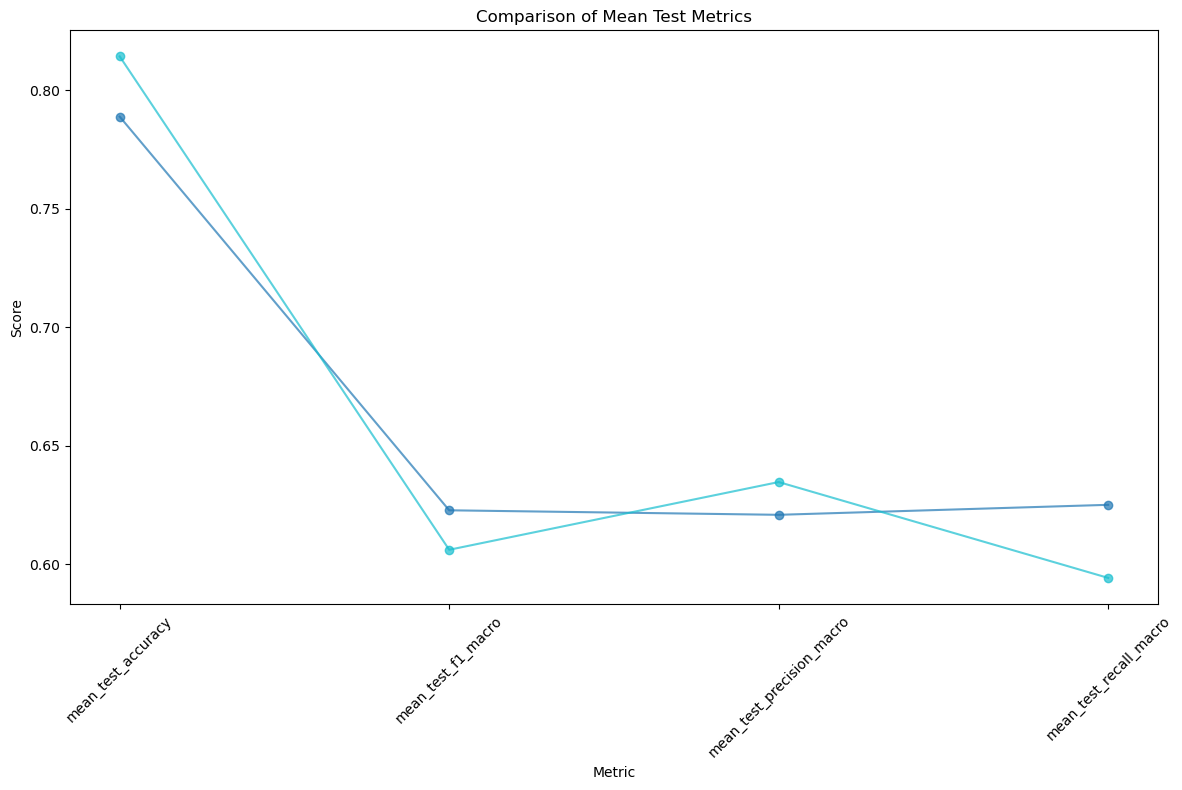

In [100]:
view_test_metrics(False, 3, results)

Como os modelos ficaram com recall e, consequentemente, f1-score baixo, isso indica que o modelo provavelmente está com bom desempenho para a classe dominante (ja que a acurácia está boa), mas não para a outra. Isso pode acontecer por conta do desbalanceamento entre as classes, então podemos tentar aplicar técnicas de balanceamento.

In [101]:
def os_smote(X, y):
    # auto faz resampling de todas as classes, menos a minoritária
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    return X_balanced, y_balanced

In [102]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('knn', KNeighborsClassifier())
])

In [103]:
param_grid = [
    {
        'knn__metric': ['minkowski'],
        'knn__p': [1, 2],  # hyperparametro usado apenas com a metrica minkowski
        'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'knn__weights': ['uniform', 'distance']
    },
    {
        'knn__metric': ['euclidean', 'manhattan'],
        'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
        'knn__weights': ['uniform', 'distance']
    }
]

In [104]:
def get_results_pipeline(g_search):
    results = pd.DataFrame(g_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_knn__metric', 'param_knn__n_neighbors', 'param_knn__p',
            'param_knn__weights', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_train_precision_macro', 
            'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [105]:
def view_test_metrics_pipeline(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = ["param_knn__n_neighbors", "param_knn__metric", "param_knn__weights", "param_knn__p"]
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

In [106]:
grid_search = train_random_search(X_train, y_train, pipeline, param_grid)
results = get_results_pipeline(grid_search)

In [68]:
results.head(10)

,mean_fit_time,mean_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__p,param_knn__weights,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
32,0.017500,0.126569,euclidean,1,NaN,uniform,1.000000,0.847885,1,1.000000,0.724178,1,1.000000,0.725262,35,1.000000,0.724494,1
2,0.023312,0.102346,minkowski,1,2.0,uniform,1.000000,0.847885,1,1.000000,0.724178,1,1.000000,0.725262,35,1.000000,0.724494,1
3,0.020627,0.099880,minkowski,1,2.0,distance,1.000000,0.847885,1,1.000000,0.724178,1,1.000000,0.725262,35,1.000000,0.724494,1
33,0.017852,0.091372,euclidean,1,NaN,distance,1.000000,0.847885,1,1.000000,0.724178,1,1.000000,0.725262,35,1.000000,0.724494,1
1,0.017175,0.611830,minkowski,1,1.0,distance,1.000000,0.838844,5,1.000000,0.706461,5,1.000000,0.702768,55,1.000000,0.704163,5
49,0.016203,0.629099,manhattan,1,NaN,distance,1.000000,0.838844,5,1.000000,0.706461,5,1.000000,0.702768,55,1.000000,0.704163,5
48,0.017317,0.650417,manhattan,1,NaN,uniform,1.000000,0.838844,5,1.000000,0.706461,5,1.000000,0.702768,55,1.000000,0.704163,5
0,0.019971,0.814413,minkowski,1,1.0,uniform,1.000000,0.838844,5,1.000000,0.706461,5,1.000000,0.702768,55,1.000000,0.704163,5
7,0.016416,0.090030,minkowski,3,2.0,distance,1.000000,0.801842,9,1.000000,0.683431,9,1.000000,0.757137,9,1.000000,0.704107,9
6,0.016717,0.089848,minkowski,3,2.0,uniform,0.923829,0.801842,9,0.842097,0.683431,9,0.950709,0.757137,9,0.881565,0.704107,9


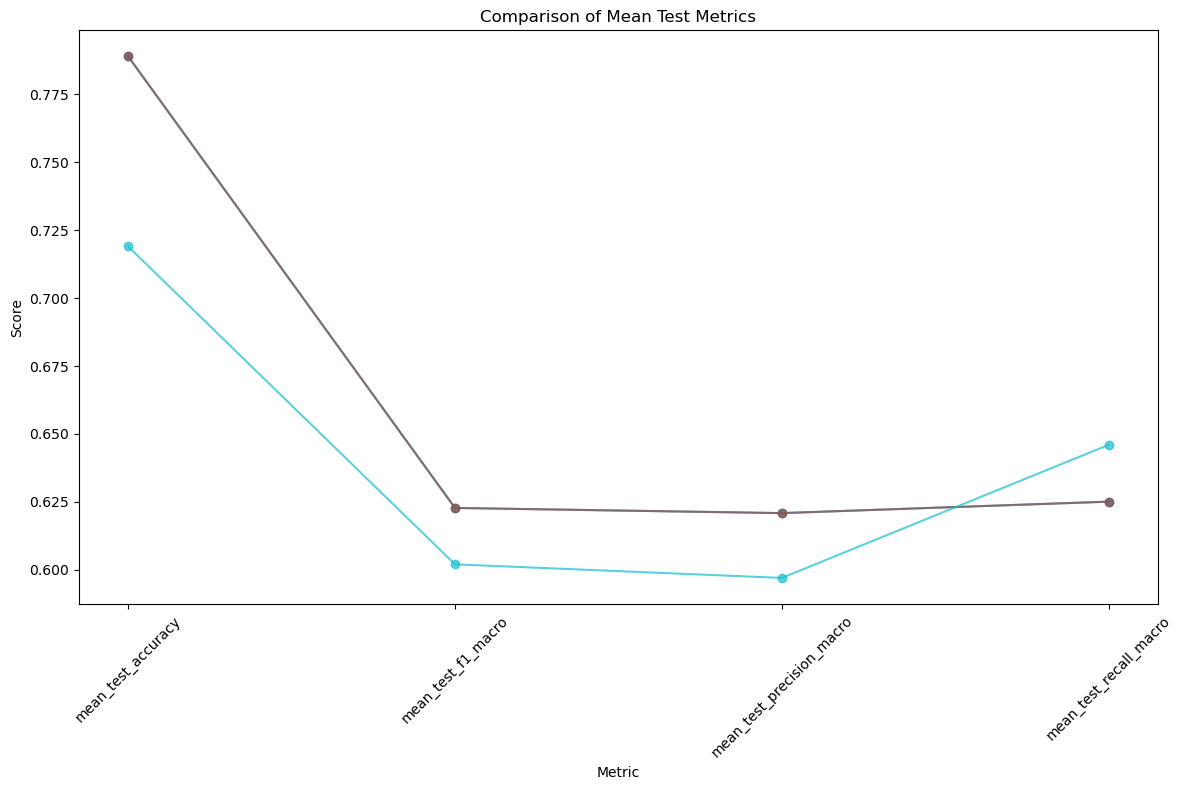

In [108]:
view_test_metrics_pipeline(False,5, results)

In [109]:
pipeline = Pipeline([
    ('oversampler', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ('knn', KNeighborsClassifier())
])

In [110]:
grid_search = train_random_search(X_train, y_train, pipeline, param_grid)
results = get_results_pipeline(grid_search)

In [111]:
results.head(10)

,mean_fit_time,mean_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__p,param_knn__weights,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
0,0.102299,0.674391,minkowski,3,1.0,distance,1.000000,0.761430,4,1.000000,0.614077,4,1.000000,0.647325,14,1.000000,0.624096,1
3,0.054993,0.678414,manhattan,1,NaN,uniform,1.000000,0.787346,1,1.000000,0.620612,1,1.000000,0.627086,18,1.000000,0.623528,2
9,0.076573,0.693076,minkowski,1,1.0,uniform,1.000000,0.787346,1,1.000000,0.620612,1,1.000000,0.627086,18,1.000000,0.623528,2
10,0.042130,0.638617,manhattan,1,NaN,distance,1.000000,0.787346,1,1.000000,0.620612,1,1.000000,0.627086,18,1.000000,0.623528,2
13,0.047119,0.101266,euclidean,1,NaN,distance,1.000000,0.749153,5,1.000000,0.599894,5,1.000000,0.630414,16,1.000000,0.608182,5
14,0.052788,0.112697,minkowski,1,2.0,uniform,1.000000,0.749153,5,1.000000,0.599894,5,1.000000,0.630414,16,1.000000,0.608182,5
6,0.067199,0.744648,manhattan,9,NaN,uniform,0.817568,0.715389,7,0.719834,0.597247,7,0.837700,0.648007,12,0.745687,0.601360,7
12,0.052595,0.658456,minkowski,9,1.0,uniform,0.817568,0.715389,7,0.719834,0.597247,7,0.837700,0.648007,12,0.745687,0.601360,7
4,0.057805,0.119602,minkowski,3,2.0,uniform,0.860713,0.695943,10,0.770254,0.596734,9,0.913667,0.656729,10,0.805257,0.595268,9
5,0.054623,0.170374,minkowski,3,2.0,distance,1.000000,0.695943,10,1.000000,0.596538,10,1.000000,0.656310,11,1.000000,0.595088,10


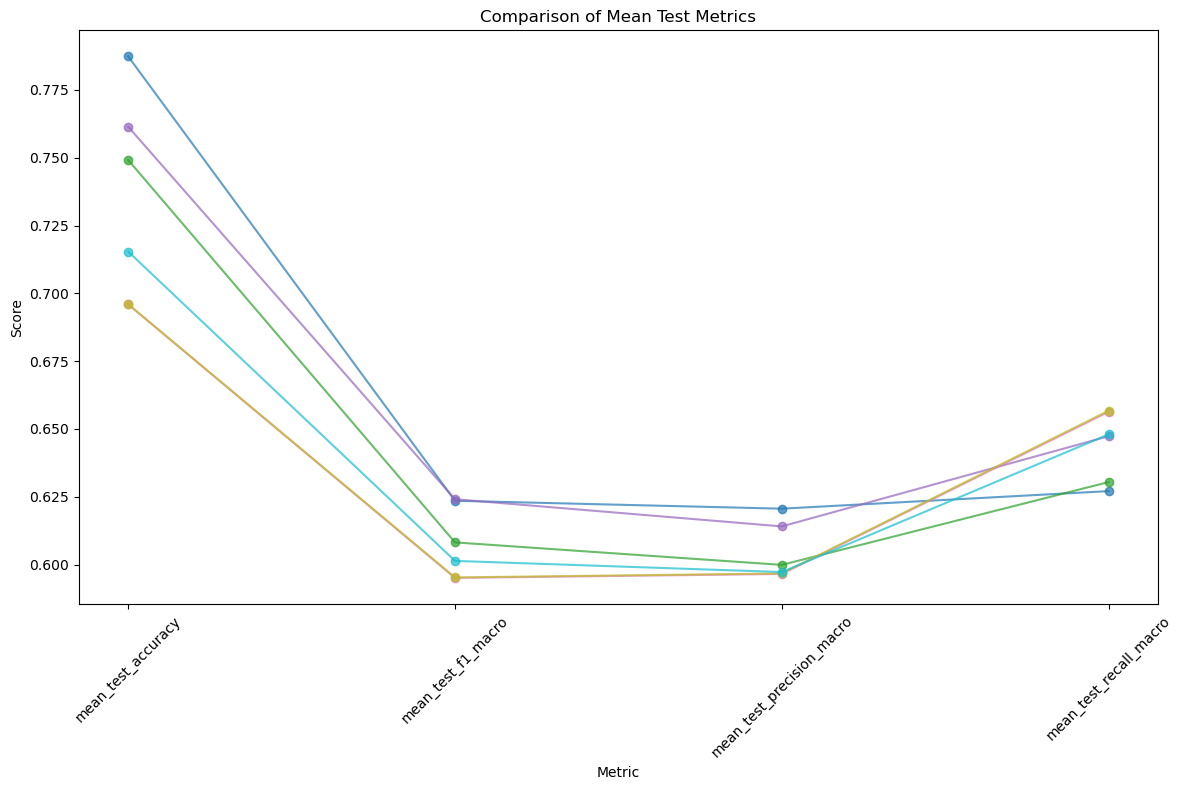

In [113]:
view_test_metrics_pipeline(False, 10, results)

In [141]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('knn', KNeighborsClassifier(
        metric='euclidean',
        n_neighbors=1,
        weights='uniform',
    ))
])

In [142]:
preds = cross_val_predict(pipeline, X_train, y_train, cv=skf, n_jobs=-1)

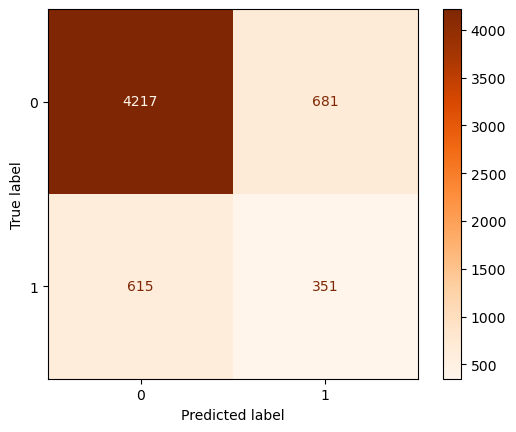

In [143]:
cm = confusion_matrix(y_train, preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=grid_search.best_estimator_.classes_)
cmd.plot(cmap=plt.cm.Oranges)
plt.show()

In [144]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.8727    0.8610    0.8668      4898
           1     0.3401    0.3634    0.3514       966

    accuracy                         0.7790      5864
   macro avg     0.6064    0.6122    0.6091      5864
weighted avg     0.7850    0.7790    0.7819      5864



In [145]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('oversampler', RandomOverSampler(random_state=42)),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=1))])

In [146]:
joblib.dump(pipeline.named_steps['knn'], 'models/knn.pkl')

['models/knn.pkl']